In [238]:
import numpy as np
import pandas as pd
import pandas_profiling # Use pandas_profiling.ProfileReport(df) instead of df.describe()
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.metrics import (classification_report, fbeta_score, f1_score, recall_score,
                             accuracy_score, precision_score, roc_curve, fbeta_score, make_scorer)
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE, ADASYN

from collections import Counter
from psycopg2 import connect
from haversine import haversine

np.set_printoptions(suppress=True)

In [157]:
df = pd.read_pickle('df.pkl')

In [365]:
df.head()

,is_late,order_id,customer_id,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_zip_code_prefix,product_id,...,order_item_id,seller_zip_code_prefix,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_vol_cm,dist_km,order_purchased_to_approved,order_approved_to_delivered_to_carrier
0,False,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 11:59:59,3149,87285b34884572647811a353c7ac498a,...,1,9350,500.0,19.0,8.0,13.0,1976.0,18.063862,0,2
1,False,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 11:59:59,47813,595fac2a385ac33a80bd5114aec74eb8,...,1,31570,400.0,19.0,13.0,19.0,4693.0,856.293763,1,0
2,False,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 11:59:59,75265,aa4383b373c6aca5d8797843e5594415,...,1,14840,420.0,24.0,19.0,21.0,9576.0,514.131043,0,0
3,False,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 11:59:59,59296,d0b61bfb1de832b15ba9d266ca96e5b0,...,1,31842,450.0,30.0,10.0,20.0,6000.0,1822.802884,0,3
4,False,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 11:59:59,9195,65266b2da20d04dbe00c5c2d3bb7859e,...,1,8752,250.0,51.0,15.0,15.0,11475.0,30.174079,0,0


Text(0, 0.5, 'Price')

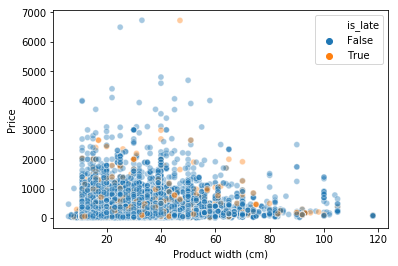

In [367]:
sns.scatterplot(df['product_width_cm'], df['price'], hue = df['is_late'], alpha = 0.4)

plt.xlabel('Product width (cm)')
plt.ylabel('Price')

#plt.savefig('width_vs_price.png', bbox_inches = 'tight')

# Modeling

In [159]:
df_y = df['is_late']
df_x = df.drop(columns = ['order_delivered_customer_date','order_estimated_delivery_date',
                          'customer_zip_code_prefix','seller_zip_code_prefix',
                          'is_late','order_id','customer_id','product_id','seller_id',
                          'order_purchase_timestamp','order_approved_at','shipping_limit_date',
                          'order_delivered_carrier_date'])
# Dropping all the non-numerical, date and y value from my x value of df
# Also dropping zip code because the model will not interpret that number correctly, and I already have lat/long

df_x.dtypes

price                                     float64
freight_value                             float64
order_item_id                               int64
product_weight_g                          float64
product_length_cm                         float64
product_height_cm                         float64
product_width_cm                          float64
product_vol_cm                            float64
dist_km                                   float64
order_purchased_to_approved                 int64
order_approved_to_delivered_to_carrier      int64
dtype: object

In [160]:
# Train/test split
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y,
                                                    stratify = df_y,  # Include proportional y's in the splits
                                                    random_state = 37)

In [166]:
# Scale my features so that everything is in z-scores
scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """


## Oversampling

In [167]:
# SMOTE
x_train_smoted, y_train_smoted = SMOTE(random_state=37).fit_sample(x_train_scaled, y_train)

In [168]:
Counter(y_smoted)

Counter({False: 75866, True: 75866})

In [318]:
# Define a confusion matrix function so that I can graph confusion matrices for each of my models
def confusion_matrix_graphic(prediction, real_y = y_test):
    conf_matrix = metrics.confusion_matrix(real_y, prediction)
    
    plt.figure(dpi=110)
    ax = sns.heatmap(conf_matrix, cmap=plt.cm.Blues, annot=True, square=True, fmt = 'g',
               xticklabels=['Not late', 'Late'],
               yticklabels=['Not late', 'Late'])
    
    cmlabels = ['True Negatives', 'False Positives',
             'False Negatives', 'True Positives']
    
    for i,t in enumerate(ax.texts):                   # Labels each box of the confusion matrix individually
        t.set_text(t.get_text() + "\n" + cmlabels[i])
    
    plt.xlabel('Predicted lateness')
    plt.ylabel('Actual lateness')
    plt.title('Confusion matrix');
    

In [ ]:
cm = confusion_matrix(y_test,logistic_pred_test)
plt.figure(figsize=(25,7))
plt.subplot(131)
ax = sns.heatmap(cm, annot=True, cmap='Blues', cbar=False,
               annot_kws={"size": 20}, fmt='g')
cmlabels = ['True Negatives', 'False Positives',
             'False Negatives', 'True Positives']
for i,t in enumerate(ax.texts):
   t.set_text(t.get_text() + "\n" + cmlabels[i])
plt.title('Confusion Matrix - Logistic Regression', size=25)
plt.xlabel('Predicted Campaign Outcome', size=20)
plt.ylabel('Actual Campaign Outcome', size=20)
labels = ['Fail', 'Success']
ax.set_xticklabels(labels, size = 20)
ax.set_yticklabels(labels, size = 20)
plt.tight_layout()
plt.savefig('Confusion_matrix_Logistic.png')
plt.savefig('Confusion_matrix_Logistic.svg')
plt.show()

## Logistic Regression

In [170]:
# Fitting and predicting with my Logistic Regression
logistic_model = LogisticRegression(random_state = 34, class_weight = 'balanced', n_jobs = -1)

logistic_model.fit(x_train_scaled, y_train)
logit_pred = logistic_model.predict(x_test_scaled)

print(metrics.f1_score(y_test, logit_pred), metrics.recall_score(y_test, logit_pred),
      metrics.precision_score(y_test, logit_pred))

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


0.21221733346976362 0.4917022285443338 0.1353079331941545


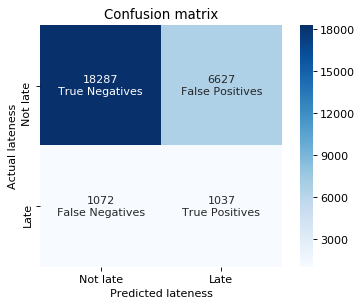

In [314]:
confusion_matrix_graphic(logit_pred)
plt.savefig('logit_confusion.png', bbox_inches = 'tight')

In [172]:
print(classification_report(y_test, logit_pred))

              precision    recall  f1-score   support

       False       0.94      0.73      0.83     24914
        True       0.14      0.49      0.21      2109

   micro avg       0.72      0.72      0.72     27023
   macro avg       0.54      0.61      0.52     27023
weighted avg       0.88      0.72      0.78     27023



In [173]:
list(zip(x_train.columns, logistic_model.coef_[0]))

[('price', 0.0026394998163000285),
 ('freight_value', 0.019627513288729633),
 ('order_item_id', -0.09234996670419095),
 ('product_weight_g', 0.028925117145455346),
 ('product_length_cm', 0.03523185441668526),
 ('product_height_cm', -0.024537080630069843),
 ('product_width_cm', -0.016427247825435087),
 ('product_vol_cm', -0.037726514340754434),
 ('dist_km', 0.2403403905709739),
 ('order_purchased_to_approved', 0.1238355905496773),
 ('order_approved_to_delivered_to_carrier', 0.5464924144297569)]

These results give preliminary evidence that latitude and longitude or both customer and seller are the most important general features of whether a shipment will be late or not.

Surprisingly, weight and volume and dimensions of the package seems to not matter much. What seems to matter a surprising amount is whether there was an additional item in the package (order_item_id). I decided to leave this metric in for possible insights like this - every additional package in an order decreases the likelihood of the package being delivered on time by 2.6%

In [174]:
# This cell calculates the logistic model's coefficient values, and turns it into interpretation
# Need to un-log these coefficients
readjusted_coefs = np.round((logistic_model.coef_[0] / scaler.scale_),8)

sorted(list(zip(abs(np.round(logistic_model.coef_[0], 8)),        # Abs val of the scaled coefficients
                            np.round(logistic_model.coef_[0], 8), # Val of the scaled coefficients
                            readjusted_coefs,                     # Unscaled val of coefficients (for interpretation)
                            x_test.columns)), reverse = True)     # Column labels

# I think all the below coefficients are in log-odds. They still need to be exponentiated and converted to p

[(0.54649241,
  0.54649241,
  0.15402177,
  'order_approved_to_delivered_to_carrier'),
 (0.24034039, 0.24034039, 0.00040803, 'dist_km'),
 (0.12383559, 0.12383559, 0.17782641, 'order_purchased_to_approved'),
 (0.09234997, -0.09234997, -0.12984203, 'order_item_id'),
 (0.03772651, -0.03772651, -1.62e-06, 'product_vol_cm'),
 (0.03523185, 0.03523185, 0.00218558, 'product_length_cm'),
 (0.02892512, 0.02892512, 7.73e-06, 'product_weight_g'),
 (0.02453708, -0.02453708, -0.00182564, 'product_height_cm'),
 (0.01962751, 0.01962751, 0.00125162, 'freight_value'),
 (0.01642725, -0.01642725, -0.00141564, 'product_width_cm'),
 (0.0026395, 0.0026395, 1.438e-05, 'price')]

In [175]:
# Once I solve the shipping distance problem, I need to exponentiate to get the coefficients into log-odds.
# Then once I have log-odds, convert to probability

np.exp(0.039588)

1.0403820484769828

In [176]:
1.00039588**100

1.0403738981754433

In [177]:
df['dist_km'].mean()

# dist_km exponent is 0.00039588

596.4359735606896

**We see below that late deliveries are, on average, ~27% farther away than deliveries that are on time**

In [178]:
# We see that late deliveries are, on average, ~27% farther away than deliveries that are on time
print(df.loc[df['is_late'] == True, 'dist_km'].mean(), df.loc[df['is_late'] == False, 'dist_km'].mean())

print((740.5 - 584.4) / 584.4)

739.8094858099133 584.2976731959608
0.2671115674195757


**I may want to include in my presentation that in my old model, I calculated the change in odds by 1 km on the margin. But I cannot extrapolate that to 1 * 100. Instead I need to recalculate my model based on every 100 km. My log-odd coefficients will be exactly 100x the old coefficients, but when I *exponentiate* that, the amount is sliiiiightly different. This is the change in probability that is compounded from 1 to 100, very similarly to compound interest.**

For example, if I had 12% interest compounded yearly, compared to 1% interest compounded monthly, 1% would be more. But a slightly smaller percentage (0.97% for instance) would be equal. My old 1 km calculation was the old, smaller percentage, and the 100 km calculation was the bigger, 12% calculation

## K-Nearest Neighbors

In [347]:
knn = KNeighborsClassifier(n_jobs = -1)

param_grid = {'n_neighbors': [i for i in range(1,10)]} # Gridsearching through squared values to find ideal KNN
knn_smote_best = GridSearchCV(knn, param_grid, cv = 2, scoring = 'roc_auc')

knn_smote_best.fit(x_train_smoted, y_train_smoted)

GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [180]:
print(knn_smote_best.best_params_, knn_smote_best.best_score_, knn_smote_best.best_estimator_)

{'n_neighbors': 5} 0.9203201533814052 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform')


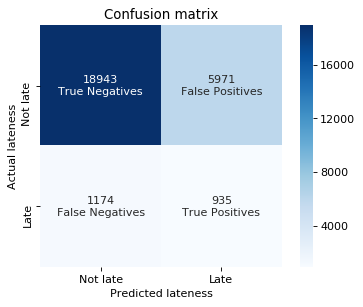

In [315]:
# Run the prediction and confusion matrix function that I defined
knn_smote_pred = knn_smote_best.best_estimator_.predict(x_test_scaled) # Take the best KNN that was found above

confusion_matrix_graphic(knn_smote_pred)
plt.savefig('knn_confusion_matrix.png', bbox_inches = 'tight')

SMOTE is better than ADASYN in my tests. I will delete ADASYN and use SMOTE from now on rather than ADASYN

## Random Forest

In [240]:
# Running the GridSearch to find roughly the best model for my Random Forest
custom_score = make_scorer(fbeta_score, beta = 2)

rf = RandomForestClassifier(n_jobs = -1, random_state = 37, class_weight = 'balanced')


param_grid = {'n_estimators' : [i ** 2 for i in range(1,10)],
              'max_depth' : [i ** 2 for i in range (3,8)]}

rf_best = GridSearchCV(rf, param_grid, cv = 2, scoring = 'roc_auc', verbose = 30)

rf_best.fit(x_train, y_train)

Fitting 2 folds for each of 45 candidates, totalling 90 fits
[CV] max_depth=9, n_estimators=1 .....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=9, n_estimators=1, score=0.2835122488301679, total=   3.6s
[CV] max_depth=9, n_estimators=1 .....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s remaining:    0.0s


[CV]  max_depth=9, n_estimators=1, score=0.3165236051502146, total=   0.6s
[CV] max_depth=9, n_estimators=4 .....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.3s remaining:    0.0s


[CV]  max_depth=9, n_estimators=4, score=0.3153410443143415, total=   0.8s
[CV] max_depth=9, n_estimators=4 .....................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.2s remaining:    0.0s


[CV]  max_depth=9, n_estimators=4, score=0.3192275709137947, total=   0.2s
[CV] max_depth=9, n_estimators=9 .....................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    5.6s remaining:    0.0s


[CV]  max_depth=9, n_estimators=9, score=0.32705718270571826, total=   0.3s
[CV] max_depth=9, n_estimators=9 .....................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.0s remaining:    0.0s


[CV]  max_depth=9, n_estimators=9, score=0.32876009146483737, total=   0.3s
[CV] max_depth=9, n_estimators=16 ....................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    6.5s remaining:    0.0s


[CV]  max_depth=9, n_estimators=16, score=0.3285707527085206, total=   0.5s
[CV] max_depth=9, n_estimators=16 ....................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    7.1s remaining:    0.0s


[CV]  max_depth=9, n_estimators=16, score=0.32900965726188225, total=   0.5s
[CV] max_depth=9, n_estimators=25 ....................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    7.7s remaining:    0.0s


[CV]  max_depth=9, n_estimators=25, score=0.3284671532846716, total=   0.6s
[CV] max_depth=9, n_estimators=25 ....................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    8.4s remaining:    0.0s


[CV]  max_depth=9, n_estimators=25, score=0.3288117720366199, total=   0.6s
[CV] max_depth=9, n_estimators=36 ....................................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    9.2s remaining:    0.0s


[CV]  max_depth=9, n_estimators=36, score=0.3302183702125599, total=   0.8s
[CV] max_depth=9, n_estimators=36 ....................................


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:   10.1s remaining:    0.0s


[CV]  max_depth=9, n_estimators=36, score=0.32437241511974607, total=   0.8s
[CV] max_depth=9, n_estimators=49 ....................................


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   11.0s remaining:    0.0s


[CV]  max_depth=9, n_estimators=49, score=0.33285163776493254, total=   1.0s
[CV] max_depth=9, n_estimators=49 ....................................


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:   12.1s remaining:    0.0s


[CV]  max_depth=9, n_estimators=49, score=0.32950670061001974, total=   1.0s
[CV] max_depth=9, n_estimators=64 ....................................


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:   13.2s remaining:    0.0s


[CV]  max_depth=9, n_estimators=64, score=0.33215342093778794, total=   1.2s
[CV] max_depth=9, n_estimators=64 ....................................


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   14.6s remaining:    0.0s


[CV]  max_depth=9, n_estimators=64, score=0.32730613034229356, total=   1.2s
[CV] max_depth=9, n_estimators=81 ....................................


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:   16.0s remaining:    0.0s


[CV]  max_depth=9, n_estimators=81, score=0.33057250799186283, total=   1.6s
[CV] max_depth=9, n_estimators=81 ....................................


[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:   17.8s remaining:    0.0s


[CV]  max_depth=9, n_estimators=81, score=0.32841435185185186, total=   1.6s
[CV] max_depth=16, n_estimators=1 ....................................
[CV]  max_depth=16, n_estimators=1, score=0.24946303919813853, total=   0.1s
[CV] max_depth=16, n_estimators=1 ....................................


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:   19.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:   19.7s remaining:    0.0s


[CV]  max_depth=16, n_estimators=1, score=0.27424197572630776, total=   0.1s
[CV] max_depth=16, n_estimators=4 ....................................


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   19.8s remaining:    0.0s


[CV]  max_depth=16, n_estimators=4, score=0.20001242313187156, total=   0.3s
[CV] max_depth=16, n_estimators=4 ....................................


[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:   20.2s remaining:    0.0s


[CV]  max_depth=16, n_estimators=4, score=0.21426839616923266, total=   0.3s
[CV] max_depth=16, n_estimators=9 ....................................


[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:   20.6s remaining:    0.0s


[CV]  max_depth=16, n_estimators=9, score=0.2070592927412922, total=   0.4s
[CV] max_depth=16, n_estimators=9 ....................................


[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:   21.2s remaining:    0.0s


[CV]  max_depth=16, n_estimators=9, score=0.2034043112513144, total=   0.5s
[CV] max_depth=16, n_estimators=16 ...................................


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:   21.8s remaining:    0.0s


[CV]  max_depth=16, n_estimators=16, score=0.1929812512876863, total=   0.6s
[CV] max_depth=16, n_estimators=16 ...................................


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   22.5s remaining:    0.0s


[CV]  max_depth=16, n_estimators=16, score=0.1926618018140899, total=   0.6s
[CV] max_depth=16, n_estimators=25 ...................................


[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed:   23.2s remaining:    0.0s


[CV]  max_depth=16, n_estimators=25, score=0.18618513323983168, total=   0.8s
[CV] max_depth=16, n_estimators=25 ...................................


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:   24.2s remaining:    0.0s


[CV]  max_depth=16, n_estimators=25, score=0.1940329647402462, total=   0.8s
[CV] max_depth=16, n_estimators=36 ...................................


[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:   25.1s remaining:    0.0s


[CV]  max_depth=16, n_estimators=36, score=0.1811157581342596, total=   1.1s
[CV] max_depth=16, n_estimators=36 ...................................


[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed:   26.3s remaining:    0.0s


[CV]  max_depth=16, n_estimators=36, score=0.19012345679012344, total=   1.1s
[CV] max_depth=16, n_estimators=49 ...................................
[CV]  max_depth=16, n_estimators=49, score=0.18754874849322842, total=   1.5s
[CV] max_depth=16, n_estimators=49 ...................................
[CV]  max_depth=16, n_estimators=49, score=0.19018274543136418, total=   1.5s
[CV] max_depth=16, n_estimators=64 ...................................
[CV]  max_depth=16, n_estimators=64, score=0.18705547652916074, total=   1.9s
[CV] max_depth=16, n_estimators=64 ...................................
[CV]  max_depth=16, n_estimators=64, score=0.18730046115643845, total=   1.9s
[CV] max_depth=16, n_estimators=81 ...................................
[CV]  max_depth=16, n_estimators=81, score=0.18687589158345222, total=   2.3s
[CV] max_depth=16, n_estimators=81 ...................................
[CV]  max_depth=16, n_estimators=81, score=0.18644548419112433, total=   2.3s
[CV] max_depth=25, n_estimat

[CV]  max_depth=49, n_estimators=49, score=0.11555182671039585, total=   1.9s
[CV] max_depth=49, n_estimators=64 ...................................
[CV]  max_depth=49, n_estimators=64, score=0.106651376146789, total=   2.4s
[CV] max_depth=49, n_estimators=64 ...................................
[CV]  max_depth=49, n_estimators=64, score=0.11120452461021094, total=   2.3s
[CV] max_depth=49, n_estimators=81 ...................................
[CV]  max_depth=49, n_estimators=81, score=0.10850462290822957, total=   3.0s
[CV] max_depth=49, n_estimators=81 ...................................
[CV]  max_depth=49, n_estimators=81, score=0.11603939232002443, total=   3.0s


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  1.9min finished


GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators='warn', n_jobs=-1, oob_score=False,
            random_state=37, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [1, 4, 9, 16, 25, 36, 49, 64, 81], 'max_depth': [9, 16, 25, 36, 49]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(fbeta_score, beta=2), verbose=30)

In [187]:
print(rf_best.best_params_, rf_best.best_score_, rf_best.best_estimator_)

{'max_depth': 36, 'n_estimators': 81} 0.6981970677185401 RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=36, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=81, n_jobs=-1, oob_score=False, random_state=37,
            verbose=0, warm_start=False)


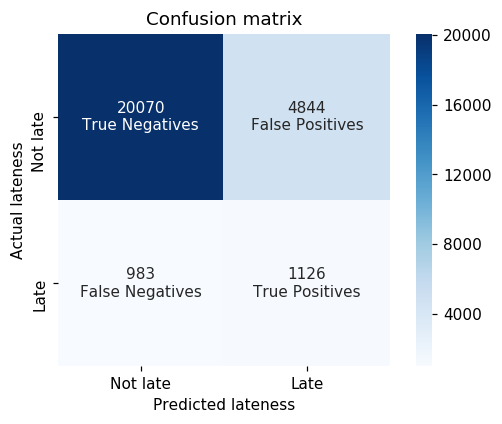

In [319]:
# Applying the way to split the threshold of 0.1 (best threshold from above), into positive and negative guesses
y_pred = pd.Series(y_probs).apply(lambda x: 0 if x < 0.1 else 1)

confusion_matrix_graphic(y_pred)
plt.savefig('rf_confusion_matrix.png', bbox_inches = 'tight')

In [312]:
4844 / (4844 + 20070)

0.19442883519306414

In [251]:
df['price'].mean() # Average cost of a product in Brazilian Real

120.12432381687115

In [333]:
# How important by percent is each of your features (adds to 1.0)
df_fi = pd.DataFrame(data = rf_best.best_estimator_.feature_importances_, index = df_x.columns)

# Show the importance of each of my features
df_fi.sort_values(by=0, ascending = False)

,0
dist_km,0.172390
freight_value,0.139419
order_approved_to_delivered_to_carrier,0.123331
price,0.122829
product_weight_g,0.103527
product_vol_cm,0.100892
product_height_cm,0.072745
product_length_cm,0.068866
product_width_cm,0.067094
order_purchased_to_approved,0.016675


For the above, I want to project what my model thinks will happen if I hypothetically reduce "order_approved_to_delivered_to_carrier" to 0. I can take an individual row, use my model's predict_proba beforehand to see likelihood. Then I can change delay to 0, and have my model predict again.

When I compare the two, this will be the lower likelihood that my model interprets over many samples, of a shipment being late

In [353]:
sample = x_test.sample(1000, random_state = 37)
pred_1 = rf_best.best_estimator_.predict_proba(sample)[:,1]

sample['order_approved_to_delivered_to_carrier'] = 0
pred_2 = rf_best.best_estimator_.predict_proba(sample)[:,1]

mean_pred_delta = np.mean(pred_1 - pred_2)

mean_pred_delta

0.02292764377050847

My model is predicting 2.3% less likelihood of each individual shipment being late when I get rid of the days of delay (what does this translate into with the 10% threshold? Maybe this would change

## Random Forest (less features)

In [328]:
df_y = df['is_late']
df_x_less = df.drop(columns = ['order_delivered_customer_date','order_estimated_delivery_date',
                          'customer_zip_code_prefix','seller_zip_code_prefix',
                          'is_late','order_id','customer_id','product_id','seller_id',
                          'order_purchase_timestamp','order_approved_at','shipping_limit_date',
                          'order_delivered_carrier_date', 'product_length_cm',
                              'product_height_cm', 'product_width_cm', 'order_item_id',
                              'order_purchased_to_approved'])
# Dropping all the non-numerical, date and y value from my x value of df
# Also dropping zip code because the model will not interpret that number correctly, and I already have lat/long

df_x_less.dtypes

price                                     float64
freight_value                             float64
product_weight_g                          float64
product_vol_cm                            float64
dist_km                                   float64
order_approved_to_delivered_to_carrier      int64
dtype: object

In [337]:
x_train_less, x_test_less, y_train, y_test = train_test_split(df_x_less, df_y,
                                                    stratify = df_y,  # Include proportional y's in the splits
                                                    random_state = 37)

In [338]:
# Running the GridSearch to find roughly the best model for my Random Forest
custom_score = make_scorer(fbeta_score, beta = 2)

rf = RandomForestClassifier(n_jobs = -1, random_state = 37, class_weight = 'balanced')


param_grid = {'n_estimators' : [i ** 2 for i in range(1,10)],
              'max_depth' : [i ** 2 for i in range (3,8)]}

rf_less_best = GridSearchCV(rf, param_grid, cv = 2, scoring = 'roc_auc', verbose = 30)

rf_less_best.fit(x_train_less, y_train)

Fitting 2 folds for each of 45 candidates, totalling 90 fits
[CV] max_depth=9, n_estimators=1 .....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=9, n_estimators=1, score=0.617287696392827, total=   2.4s
[CV] max_depth=9, n_estimators=1 .....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.4s remaining:    0.0s


[CV]  max_depth=9, n_estimators=1, score=0.6347425351839178, total=   0.6s
[CV] max_depth=9, n_estimators=4 .....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.0s remaining:    0.0s


[CV]  max_depth=9, n_estimators=4, score=0.6617790948862401, total=   1.0s
[CV] max_depth=9, n_estimators=4 .....................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.2s remaining:    0.0s


[CV]  max_depth=9, n_estimators=4, score=0.6583935984400366, total=   0.3s
[CV] max_depth=9, n_estimators=9 .....................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    4.6s remaining:    0.0s


[CV]  max_depth=9, n_estimators=9, score=0.6813543393318527, total=   0.3s
[CV] max_depth=9, n_estimators=9 .....................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    5.0s remaining:    0.0s


[CV]  max_depth=9, n_estimators=9, score=0.6745718575342687, total=   0.3s
[CV] max_depth=9, n_estimators=16 ....................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    5.5s remaining:    0.0s


[CV]  max_depth=9, n_estimators=16, score=0.6833018436349825, total=   0.5s
[CV] max_depth=9, n_estimators=16 ....................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    6.1s remaining:    0.0s


[CV]  max_depth=9, n_estimators=16, score=0.6839374052552007, total=   0.5s
[CV] max_depth=9, n_estimators=25 ....................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    6.7s remaining:    0.0s


[CV]  max_depth=9, n_estimators=25, score=0.6852536865037389, total=   0.6s
[CV] max_depth=9, n_estimators=25 ....................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    7.5s remaining:    0.0s


[CV]  max_depth=9, n_estimators=25, score=0.6853075448744861, total=   0.6s
[CV] max_depth=9, n_estimators=36 ....................................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    8.2s remaining:    0.0s


[CV]  max_depth=9, n_estimators=36, score=0.6857737984871075, total=   0.8s
[CV] max_depth=9, n_estimators=36 ....................................


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    9.2s remaining:    0.0s


[CV]  max_depth=9, n_estimators=36, score=0.6860529143254981, total=   0.8s
[CV] max_depth=9, n_estimators=49 ....................................


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   10.1s remaining:    0.0s


[CV]  max_depth=9, n_estimators=49, score=0.6860601015322461, total=   1.0s
[CV] max_depth=9, n_estimators=49 ....................................


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:   11.2s remaining:    0.0s


[CV]  max_depth=9, n_estimators=49, score=0.6876508516502384, total=   2.2s
[CV] max_depth=9, n_estimators=64 ....................................


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:   13.5s remaining:    0.0s


[CV]  max_depth=9, n_estimators=64, score=0.6857734263684183, total=   1.9s
[CV] max_depth=9, n_estimators=64 ....................................


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   15.5s remaining:    0.0s


[CV]  max_depth=9, n_estimators=64, score=0.687885779002269, total=   2.4s
[CV] max_depth=9, n_estimators=81 ....................................


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:   18.1s remaining:    0.0s


[CV]  max_depth=9, n_estimators=81, score=0.6859048011801981, total=   2.2s
[CV] max_depth=9, n_estimators=81 ....................................


[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:   20.5s remaining:    0.0s


[CV]  max_depth=9, n_estimators=81, score=0.6888158849540608, total=   1.9s
[CV] max_depth=16, n_estimators=1 ....................................
[CV]  max_depth=16, n_estimators=1, score=0.5675630997432686, total=   0.1s
[CV] max_depth=16, n_estimators=1 ....................................


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:   22.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:   22.9s remaining:    0.0s


[CV]  max_depth=16, n_estimators=1, score=0.5674003972304157, total=   0.1s
[CV] max_depth=16, n_estimators=4 ....................................


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   23.0s remaining:    0.0s


[CV]  max_depth=16, n_estimators=4, score=0.6098105125965391, total=   0.3s
[CV] max_depth=16, n_estimators=4 ....................................


[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:   23.4s remaining:    0.0s


[CV]  max_depth=16, n_estimators=4, score=0.6195690572662009, total=   0.3s
[CV] max_depth=16, n_estimators=9 ....................................


[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:   23.9s remaining:    0.0s


[CV]  max_depth=16, n_estimators=9, score=0.6453487142842596, total=   0.6s
[CV] max_depth=16, n_estimators=9 ....................................


[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:   24.6s remaining:    0.0s


[CV]  max_depth=16, n_estimators=9, score=0.64005920905071, total=   0.6s
[CV] max_depth=16, n_estimators=16 ...................................


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:   25.3s remaining:    0.0s


[CV]  max_depth=16, n_estimators=16, score=0.6590312351691674, total=   0.7s
[CV] max_depth=16, n_estimators=16 ...................................


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   26.2s remaining:    0.0s


[CV]  max_depth=16, n_estimators=16, score=0.6521577076131093, total=   0.8s
[CV] max_depth=16, n_estimators=25 ...................................


[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed:   27.1s remaining:    0.0s


[CV]  max_depth=16, n_estimators=25, score=0.6646914479784332, total=   1.0s
[CV] max_depth=16, n_estimators=25 ...................................


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:   28.3s remaining:    0.0s


[CV]  max_depth=16, n_estimators=25, score=0.6544423449246896, total=   1.0s
[CV] max_depth=16, n_estimators=36 ...................................


[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:   29.4s remaining:    0.0s


[CV]  max_depth=16, n_estimators=36, score=0.6678945483969279, total=   1.5s
[CV] max_depth=16, n_estimators=36 ...................................


[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed:   31.0s remaining:    0.0s


[CV]  max_depth=16, n_estimators=36, score=0.6600071947690891, total=   2.2s
[CV] max_depth=16, n_estimators=49 ...................................
[CV]  max_depth=16, n_estimators=49, score=0.6704114957814764, total=   2.0s
[CV] max_depth=16, n_estimators=49 ...................................
[CV]  max_depth=16, n_estimators=49, score=0.661233252942269, total=   2.3s
[CV] max_depth=16, n_estimators=64 ...................................
[CV]  max_depth=16, n_estimators=64, score=0.6723879365413143, total=   2.4s
[CV] max_depth=16, n_estimators=64 ...................................
[CV]  max_depth=16, n_estimators=64, score=0.6663269075737314, total=   2.0s
[CV] max_depth=16, n_estimators=81 ...................................
[CV]  max_depth=16, n_estimators=81, score=0.67301470704398, total=   3.1s
[CV] max_depth=16, n_estimators=81 ...................................
[CV]  max_depth=16, n_estimators=81, score=0.666298837233298, total=   2.5s
[CV] max_depth=25, n_estimators=1 .....

[CV]  max_depth=49, n_estimators=49, score=0.6894656765451035, total=   1.9s
[CV] max_depth=49, n_estimators=64 ...................................
[CV]  max_depth=49, n_estimators=64, score=0.6884863830438911, total=   2.5s
[CV] max_depth=49, n_estimators=64 ...................................
[CV]  max_depth=49, n_estimators=64, score=0.692013400352575, total=   2.4s
[CV] max_depth=49, n_estimators=81 ...................................
[CV]  max_depth=49, n_estimators=81, score=0.6904297940414394, total=   3.1s
[CV] max_depth=49, n_estimators=81 ...................................
[CV]  max_depth=49, n_estimators=81, score=0.6927011913529482, total=   3.1s


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  2.1min finished


GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators='warn', n_jobs=-1, oob_score=False,
            random_state=37, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [1, 4, 9, 16, 25, 36, 49, 64, 81], 'max_depth': [9, 16, 25, 36, 49]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=30)

## ROC Curve

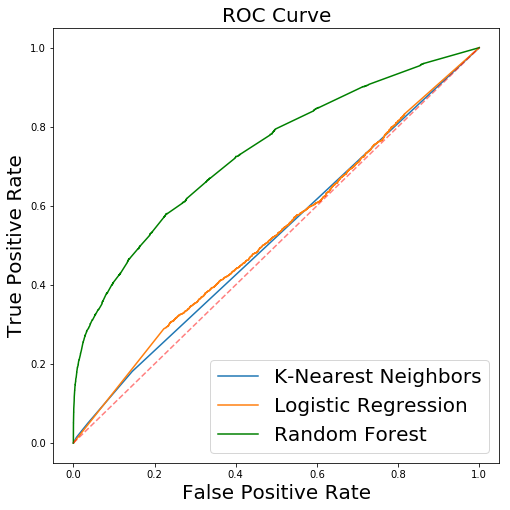

In [346]:
# Graphing a ROC curve for all my plots

# Set the data for my plots
logit_fpr, logit_tpr, _ = roc_curve(y_test, logistic_model.predict_proba(x_test)[:,1])
knn_fpr, knn_tpr, _ = roc_curve(y_test, knn_smote_best.predict_proba(x_test)[:,1])
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_best.predict_proba(x_test)[:,1])
#rf_less_fpr, rf_less_tpr, _ = roc_curve(y_test, rf_less_best.predict_proba(x_test_less)[:,1])


# Plot the ROC
fig, ax = plt.subplots(figsize = (8,8))

plt.title('ROC Curve', fontsize = 20)
plt.xlabel('False Positive Rate', fontsize = 20)
plt.ylabel('True Positive Rate', fontsize = 20)
plt.plot(knn_fpr, knn_tpr, label = 'K-Nearest Neighbors')
plt.plot(logit_fpr, logit_tpr, label = 'Logistic Regression')
plt.plot(rf_fpr, rf_tpr, 'g', label = 'Random Forest')
#plt.plot(rf_less_fpr, rf_less_tpr, 'r', label = 'Random Forest (Less)')
plt.plot([0, 1], 'r--', alpha = 0.5) # y = x line
plt.legend(fontsize = 20)

#plt.savefig('roc_curve.png', bbox_inches = 'tight')

In [356]:
# My Random Forest ROC_AUC
metrics.roc_auc_score(y_test, rf_best.best_estimator_.predict_proba(x_test)[:,1])

0.7353557784535083

In [341]:
df_fi.sort_values(by=0, ascending = False)

,0
dist_km,0.172390
freight_value,0.139419
order_approved_to_delivered_to_carrier,0.123331
price,0.122829
product_weight_g,0.103527
product_vol_cm,0.100892
product_height_cm,0.072745
product_length_cm,0.068866
product_width_cm,0.067094
order_purchased_to_approved,0.016675


Simplifying my features didn't do anything to make the ROC curve better, or dramatically change the interpretation around my variables

In [340]:
# How important by percent is each of your features (adds to 1.0)
df_less_fi = pd.DataFrame(data = rf_less_best.best_estimator_.feature_importances_, index = df_x_less.columns)

# Show the importance of each of my features
df_less_fi.sort_values(by=0, ascending = False)

,0
dist_km,0.225272
freight_value,0.177194
price,0.169503
product_vol_cm,0.160473
product_weight_g,0.141792
order_approved_to_delivered_to_carrier,0.125766


In [274]:
y_probs = rf_best.predict_proba(x_test)[:,1]
precisions = []
thresholds = []
for t in range(0,100,5):
    y_pred = pd.Series(y_probs).apply(lambda x: 0 if x<t / 100 else 1)
    precisions.append(fbeta_score(y_test, y_pred, beta = 2))
    thresholds.append(t/100)
print(np.argmax(precisions)) #the index of the best fbeta
print(thresholds[np.argmax(precisions)]) #the best threshold for your model
print(max(precisions)) # Precisions = fbeta

2
0.1
0.3908093849784812


In [309]:
print('Logistic Regression')
print(f'Recall Score: {recall_score(y_test, logit_pred)}')
print(f'Precision Score: {precision_score(y_test, logit_pred)}')
print(f'FBeta Score: {fbeta_score(y_test, logit_pred, beta = 2)}')

print('')
print('K-Nearest Neighbors')
print(f'Recall Score: {recall_score(y_test, knn_smote_pred)}')
print(f'Precision Score: {precision_score(y_test, knn_smote_pred)}')
print(f'FBeta Score: {fbeta_score(y_test, knn_smote_pred, beta = 2)}')

print('')
print('Random Forest')
print(f'Recall Score: {recall_score(y_test, y_pred)}')
print(f'Precision Score: {precision_score(y_test, y_pred)}')
print(f'FBeta Score: {fbeta_score(y_test, y_pred, beta = 2)}')

Logistic Regression
Recall Score: 0.4917022285443338
Precision Score: 0.1353079331941545
FBeta Score: 0.3220496894409937

K-Nearest Neighbors
Recall Score: 0.44333807491702226
Precision Score: 0.13538951636258326
FBeta Score: 0.3047190718289662

Random Forest
Recall Score: 0.5339023233760076
Precision Score: 0.18860971524288106
FBeta Score: 0.3908093849784812


## What's the Business Case? Who cares?

In [370]:
df['order_purchase_timestamp'].sort_values()

33875    2016-09-15 12:16:38
33874    2016-09-15 12:16:38
33876    2016-09-15 12:16:38
102779   2016-10-03 09:44:50
31328    2016-10-03 16:56:50
102041   2016-10-03 21:01:41
107968   2016-10-03 21:13:36
97391    2016-10-03 22:06:03
7406     2016-10-03 22:31:31
68375    2016-10-03 22:44:10
36959    2016-10-03 22:51:30
86800    2016-10-04 09:06:10
70507    2016-10-04 09:16:33
73855    2016-10-04 09:59:03
39513    2016-10-04 10:16:04
81730    2016-10-04 10:41:17
9289     2016-10-04 11:03:14
35361    2016-10-04 12:06:11
17984    2016-10-04 12:53:17
65061    2016-10-04 13:11:29
65060    2016-10-04 13:11:29
27264    2016-10-04 13:15:46
93291    2016-10-04 13:15:52
92732    2016-10-04 13:16:57
107478   2016-10-04 13:22:56
62721    2016-10-04 13:30:13
91172    2016-10-04 13:40:43
72571    2016-10-04 13:45:08
1530     2016-10-04 14:13:22
93227    2016-10-04 14:23:50
                 ...        
17530    2018-08-28 19:31:41
19075    2018-08-28 19:32:05
19076    2018-08-28 19:32:05
19074    2018-

In [371]:
df[(df['order_purchase_timestamp'] > '2017-08-29') & df['is_late'] == True]

,is_late,order_id,customer_id,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_zip_code_prefix,product_id,...,order_item_id,seller_zip_code_prefix,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_vol_cm,dist_km,order_purchased_to_approved,order_approved_to_delivered_to_carrier
20,True,203096f03d82e0dffbc41ebc2e2bcfb7,d2b091571da224a1b36412c18bc3bbfe,2017-09-18 14:31:30,2017-09-19 04:04:09,2017-10-06 17:50:03,2017-10-09 22:23:46,2017-09-28 11:59:59,4001,5ac9d9e379c606e36a8094a6046f75dc,...,1,4438,525.0,21.0,16.0,13.0,4368.0,11.846404,0,17
25,True,fbf9ac61453ac646ce8ad9783d7d0af6,3a874b4d4c4b6543206ff5d89287f0c3,2018-02-20 23:46:53,2018-02-22 02:30:46,2018-02-26 22:25:22,2018-03-21 22:03:54,2018-03-12 11:59:59,21715,7b717060aa783eb7f23a747a3a733dd7,...,1,9220,500.0,16.0,12.0,22.0,4224.0,326.895894,1,4
42,True,6ea2f835b4556291ffdc53fa0b3b95e8,c7340080e394356141681bd4c9b8fe31,2017-11-24 21:27:48,2017-11-25 00:21:09,2017-12-13 21:14:05,2017-12-28 18:59:23,2017-12-21 11:59:59,19400,be021417a6acb56b9b50d3fd2714baa8,...,1,89165,14300.0,38.0,34.0,34.0,43928.0,634.595829,0,18
58,True,66e4624ae69e7dc89bd50222b59f581f,684fa6da5134b9e4dab731e00011712d,2018-03-09 14:50:15,2018-03-09 15:40:39,2018-03-15 00:31:19,2018-04-03 13:28:46,2018-04-02 11:59:59,49030,b37b72d5a56f887725c2862184b8cab8,...,1,3126,150.0,19.0,4.0,11.0,836.0,1727.593999,0,5
59,True,66e4624ae69e7dc89bd50222b59f581f,684fa6da5134b9e4dab731e00011712d,2018-03-09 14:50:15,2018-03-09 15:40:39,2018-03-15 00:31:19,2018-04-03 13:28:46,2018-04-02 11:59:59,49030,b37b72d5a56f887725c2862184b8cab8,...,2,3126,150.0,19.0,4.0,11.0,836.0,1727.593999,0,5
110,True,6a0a8bfbbe700284feb0845d95e0867f,68451b39b1314302c08c65a29f1140fc,2017-11-22 11:32:22,2017-11-22 11:46:50,2017-11-27 13:39:35,2017-12-28 19:43:00,2017-12-11 11:59:59,20740,f8a8f05a35976a91aed5cccc3992c357,...,1,14940,1500.0,45.0,15.0,35.0,23625.0,580.439096,0,5
115,True,a5474c0071dd5d1074e12d417078bbd0,ef15b3240b2083e0487762ee2978d2b8,2018-07-30 22:41:44,2018-08-01 02:50:15,2018-08-02 10:35:00,2018-08-03 19:28:47,2018-08-02 11:59:59,6434,1f75be631e988bb0ad750e60e18d043b,...,1,4208,200.0,25.0,10.0,15.0,3750.0,29.172345,1,1
122,True,9d531c565e28c3e0d756192f84d8731f,d4faa220408c20e53595d2950f361f3b,2017-11-28 21:00:44,2017-12-01 09:31:15,2017-12-14 20:37:43,2018-01-23 21:38:52,2017-12-22 11:59:59,24933,807b2de93dbb064bbc82dc6ac963bc61,...,1,5734,500.0,16.0,30.0,16.0,7680.0,395.882456,2,13
128,True,8fc207e94fa91a7649c5a5dab690272a,c69f8b33e62ecb30ff78ae46d7fb9241,2017-11-26 17:49:46,2017-11-26 17:58:34,2017-11-28 23:17:09,2018-01-20 13:42:22,2017-12-19 11:59:59,25540,f2e53dd1670f3c376518263b3f71424d,...,1,14940,1975.0,41.0,13.0,31.0,16523.0,570.563531,0,2
164,True,33a3edb84b9df4cb49546859b990ac6d,35ec6c1ca9e5844c5ca94214cce16dca,2018-02-21 17:15:49,2018-02-22 16:10:41,2018-02-23 22:42:43,2018-03-22 00:03:53,2018-03-16 11:59:59,36021,389d119b48cf3043d311335e499d9c6b,...,1,15025,1750.0,37.0,22.0,40.0,32560.0,636.114467,0,1


**Need to choose between using ROC_AUC and F1_Score to score my model when I am making it.**

Conceptually, the ROC_AUC maximizes your model's performance at all levels of threshold (At one corner, it'll classify as 1 when it is 0.01 confident, at the other corner it will only classify upon 0.99 confidence. Everything else in the middle operates on some spectrum of confidence. That spectrum of confidence will result in different False Positive and False Negative rates, and you have to choose where your *actual model* classifies based on your preferences: precision, recall, sensitivity, specificity)

Conceptually, the F1_Score finds the harmonic mean of your optimized precision and recall. To compare it with the ROC_AUC scoring, it'll score your model by picking the threshold that maximizes the harmonic mean between precision and recall, rather than providing the expected results at every threshold (It'll simply pick "the best" threshold, given the weights that you assign to precision and recall, with a default of a 50/50 split)

Jonathan recommends Random Forest for my problem - I'm likely to have late shipments overlapping with not late shipments, without any way to separate them in my dataset.

## Scoring

I'm going to be scoring with weights of 60% for recall and 40% for precision, since I think predicting late deliveries is more important. You can do something like send an email warning that the shipment is going to be late.

# Lessons from this Project

1. Be careful with cross-validation - don't use it if there's no point. If I have enough data, I can make sure that I don't create any oversampling data leakage. Example: I had data leakage in this project because of SMOTE that was used in the cross-validation - giving very different results than what I get on my final test


2. Consider beforehand if I really need to cross-validate, or if I should split a validation set ahead of time


3. You need to be careful with your scoring metric. I scored everything with "roc_auc", thinking that would lead to the best apples-to-apples comparison across the board before I knew what I wanted to score my model on. But instead, it trained and picked the best model on very different performances (KNN and Logistic Regression were heavier on recall, while RF was much heavier on precision). RF *clearly* outperformed the others in the ROC curve, but underperformed in the proper FBeta weighting. **If I didn't graph my ROCs and confusion matrix, I would have thought that my Random Forest was my worse model**